Import Dataset from kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download divg07/casia-20-image-tampering-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset
License(s): unknown
100% 2.55G/2.56G [00:14<00:00, 283MB/s]
100% 2.56G/2.56G [00:14<00:00, 187MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/casia-20-image-tampering-detection-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

Data Preprocessing

In [4]:
import os
import cv2
from tqdm import tqdm

# Define paths for the dataset
base_dir = "/content/CASIA2"  # Base directory containing the dataset
authentic_dir = os.path.join(base_dir, "Au")  # Directory for authentic/untampered images
tampered_dir = os.path.join(base_dir, "Tp")  # Directory for tampered/forged images
groundtruth_dir = os.path.join(base_dir, "CASIA 2 Groundtruth")  # Directory for ground truth masks

# Directory to store preprocessed data
preprocessed_dir = "/content/CASIA2_preprocessed"
os.makedirs(preprocessed_dir, exist_ok=True)  # Create the base preprocessed directory if it doesn't exist

# Subdirectories for storing preprocessed authentic images, tampered images, and masks
authentic_out_dir = os.path.join(preprocessed_dir, "authentic")
tampered_out_dir = os.path.join(preprocessed_dir, "tampered")
masks_out_dir = os.path.join(preprocessed_dir, "masks")

# Create subdirectories if they don't already exist
for folder in [authentic_out_dir, tampered_out_dir, masks_out_dir]:
    os.makedirs(folder, exist_ok=True)

# Function to preprocess images or masks
def preprocess_images(input_dir, output_dir, size=(512, 512), is_mask=False):
    """
    Preprocess images by resizing and optionally thresholding masks.

    Args:
        input_dir (str): Directory containing input images.
        output_dir (str): Directory to save preprocessed images.
        size (tuple): Target size for resizing (width, height).
        is_mask (bool): Whether the input is a binary mask (default: False).
    """
    for img_name in tqdm(os.listdir(input_dir), desc=f"Processing {input_dir}"):
        img_path = os.path.join(input_dir, img_name)  # Full path to the input image
        # Read the image (grayscale for masks, color for regular images)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if is_mask else cv2.IMREAD_COLOR)
        if img is None:  # Skip if the image cannot be read
            print(f"Warning: Could not read {img_path}")
            continue
        # Resize the image to the specified size
        img_resized = cv2.resize(img, size)
        if is_mask:  # If processing masks, ensure binary format
            _, img_resized = cv2.threshold(img_resized, 127, 255, cv2.THRESH_BINARY)
        # Save the preprocessed image to the output directory
        output_path = os.path.join(output_dir, img_name)
        cv2.imwrite(output_path, img_resized)

# # Preprocess authentic images
# preprocess_images(authentic_dir, authentic_out_dir)

# Preprocess tampered/forged images
preprocess_images(tampered_dir, tampered_out_dir)

# Preprocess ground truth masks
preprocess_images(groundtruth_dir, masks_out_dir, is_mask=True)


Processing /content/CASIA2/Tp:  34%|███▎      | 1720/5125 [00:20<00:36, 93.18it/s]

Processing /content/CASIA2/Tp:  66%|██████▌   | 3384/5125 [00:39<00:16, 107.02it/s]

Processing /content/CASIA2/CASIA 2 Groundtruth: 100%|██████████| 5123/5123 [00:16<00:00, 301.43it/s]


Data Visualization

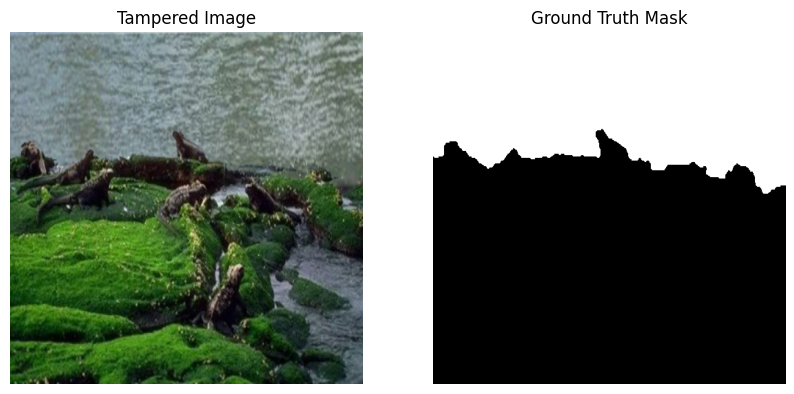

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

def find_corresponding_mask(image_name, mask_dir):
    """
    Finds the corresponding mask file for a given tampered image based on the naming convention.
    """
    base_name = os.path.splitext(image_name)[0]  # Get the base name without extension
    mask_name = f"{base_name}_gt"  # Append '_gt' to match the ground truth mask
    for mask_file in os.listdir(mask_dir):
        if os.path.splitext(mask_file)[0] == mask_name:  # Match the base name with '_gt'
            return os.path.join(mask_dir, mask_file)
    return None  # Return None if no matching mask is found

def show_sample(image_dir, mask_dir, image_name):
    """
    Displays a tampered image and its corresponding ground truth mask.
    """
    image_path = os.path.join(image_dir, image_name)
    mask_path = find_corresponding_mask(image_name, mask_dir)

    if mask_path is None:
        print(f"Mask not found for {image_name}")
        return

    # Load image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Plot the tampered image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Tampered Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.show()

# Example usage
tampered_dir = "/content/CASIA2_preprocessed/tampered"
mask_dir = "/content/CASIA2_preprocessed/masks"

# Replace 'example.jpg' with an actual filename from your tampered images folder
sample_image_name = "Tp_D_CND_M_N_ani00018_sec00096_00138.tif"  # Adjust this to match one of your image names
show_sample(tampered_dir, mask_dir, sample_image_name)


Storing the Dataset info in a Dataframe

In [6]:
import os
import pandas as pd

# Directories
tampered_dir = "/content/CASIA2_preprocessed/tampered"
masks_dir = "/content/CASIA2_preprocessed/masks"

# Function to extract base name (without extension)
def get_base_name(file_name):
    return os.path.splitext(file_name)[0]

# Get file names and paths
tampered_files = os.listdir(tampered_dir)
tampered_paths = [os.path.join(tampered_dir, f) for f in tampered_files]
mask_files = os.listdir(masks_dir)
mask_paths = [os.path.join(masks_dir, f) for f in mask_files]

# Map tampered images to their corresponding ground truth masks
mapped_data = []
for tampered_file, tampered_path in zip(tampered_files, tampered_paths):
    tampered_base = get_base_name(tampered_file)
    corresponding_mask_file = f"{tampered_base}_gt"

    for mask_file, mask_path in zip(mask_files, mask_paths):
        if get_base_name(mask_file) == corresponding_mask_file:
            mapped_data.append({
                "tampered_image_file_name": tampered_file,
                "tampered_image_file_path": tampered_path,
                "groundtruth_image_file_name": mask_file,
                "groundtruth_image_file_path": mask_path
            })
            break

# Create DataFrame
df = pd.DataFrame(mapped_data)

# Display first few rows of the DataFrame
df.head()


,tampered_image_file_name,tampered_image_file_path,groundtruth_image_file_name,groundtruth_image_file_path
0,Tp_S_NNN_S_N_sec00027_sec00027_10789.jpg,/content/CASIA2_preprocessed/tampered/Tp_S_NNN...,Tp_S_NNN_S_N_sec00027_sec00027_10789_gt.png,/content/CASIA2_preprocessed/masks/Tp_S_NNN_S_...
1,Tp_D_NRN_S_N_cha10109_ani00070_11586.jpg,/content/CASIA2_preprocessed/tampered/Tp_D_NRN...,Tp_D_NRN_S_N_cha10109_ani00070_11586_gt.png,/content/CASIA2_preprocessed/masks/Tp_D_NRN_S_...
2,Tp_D_CRN_S_N_pla00019_pla00020_10954.jpg,/content/CASIA2_preprocessed/tampered/Tp_D_CRN...,Tp_D_CRN_S_N_pla00019_pla00020_10954_gt.png,/content/CASIA2_preprocessed/masks/Tp_D_CRN_S_...
3,Tp_S_NNN_S_N_nat10158_nat10158_12025.jpg,/content/CASIA2_preprocessed/tampered/Tp_S_NNN...,Tp_S_NNN_S_N_nat10158_nat10158_12025_gt.png,/content/CASIA2_preprocessed/masks/Tp_S_NNN_S_...
4,Tp_D_NRN_S_N_arc00035_ani00070_00255.tif,/content/CASIA2_preprocessed/tampered/Tp_D_NRN...,Tp_D_NRN_S_N_arc00035_ani00070_00255_gt.png,/content/CASIA2_preprocessed/masks/Tp_D_NRN_S_...


Data Splitting

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df_mapped is the dataframe containing the data
# Split the data into train, test, and validation sets
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)  # 70% training, 30% for test + validation
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # Split the 30% equally for test and validation

# Print a summary of the splits
print(f"Train Set Size: {len(train_data)}")
print(f"Test Set Size: {len(test_data)}")
print(f"Validation Set Size: {len(val_data)}")


Train Set Size: 3486
Test Set Size: 747
Validation Set Size: 748


MFAN Model Creation

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=12, padding=12)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=24, padding=24)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=36, padding=36)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv_pool = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv_out = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.conv_pool(self.pool(x))
        x5 = nn.functional.interpolate(x5, size=x1.size()[2:], mode="bilinear", align_corners=False)
        x_out = self.conv_out(torch.cat([x1, x2, x3, x4, x5], dim=1))
        return x_out

class FeatureRecalibration(nn.Module):
    def __init__(self, channels):
        super(FeatureRecalibration, self).__init__()
        self.channel_weights = nn.Sequential(
            nn.Conv2d(channels, channels // 2, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // 2, channels, kernel_size=1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        attention = self.channel_weights(x)
        return x * attention

class MFAN(nn.Module):
    def __init__(self):
        super(MFAN, self).__init__()
        backbone = models.resnet50(pretrained=True)

        # Encoder
        self.enc1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool)
        self.enc2 = backbone.layer1
        self.enc3 = backbone.layer2
        self.enc4 = backbone.layer3

        # ASPP
        self.aspp = ASPP(1024, 256)

        # Feature Fusion
        self.fuse = nn.Conv2d(256 + 256 + 64, 256, kernel_size=1)

        # Feature Recalibration
        self.recalibration = FeatureRecalibration(256)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False),
            nn.Sigmoid()  # Ensure output is in range [0, 1]
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # ASPP
        aspp_out = self.aspp(enc4)

        # Resize for compatibility
        enc2_resized = nn.functional.interpolate(enc2, size=aspp_out.size()[2:], mode="bilinear", align_corners=False)
        enc1_resized = nn.functional.interpolate(enc1, size=aspp_out.size()[2:], mode="bilinear", align_corners=False)

        # Fuse Features
        fused = self.fuse(torch.cat([aspp_out, enc2_resized, enc1_resized], dim=1))

        # Feature Recalibration
        recalibrated = self.recalibration(fused)

        # Decoder
        output = self.decoder(recalibrated)
        return output

# Dataset class
class TamperDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        tampered_image_path = self.dataframe.iloc[idx]['tampered_image_file_path']
        groundtruth_image_path = self.dataframe.iloc[idx]['groundtruth_image_file_path']

        tampered_image = Image.open(tampered_image_path).convert("RGB")
        groundtruth_image = Image.open(groundtruth_image_path).convert("L")

        if self.transform:
            tampered_image = self.transform(tampered_image)
            groundtruth_image = self.transform(groundtruth_image)

        return tampered_image, groundtruth_image

# # Load train_data DataFrame
# train_data = pd.read_csv("train_data.csv")

# # Use first 5 rows of training data
train_data = train_data.head(500)

# Transforms
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Create DataLoader
train_dataset = TamperDataset(train_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Instantiate the model
model = MFAN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss functions
class MFANLoss(nn.Module):
    def __init__(self, alpha=0.2):
        super(MFANLoss, self).__init__()
        self.alpha = alpha
        self.bce_loss = nn.BCELoss()

    def forward(self, output, target, aux_output):
        loc_loss = self.bce_loss(output, target)
        aux_loss = self.bce_loss(aux_output, target)
        total_loss = loc_loss + self.alpha * aux_loss
        return total_loss

# Optimizer and scheduler
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
num_epochs = 50
criterion = MFANLoss()

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets, outputs)  # Fix loss computation to use correct outputs

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.numel()

    # Step scheduler
    scheduler.step(epoch_loss)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


Epoch [1/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [2/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [3/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [4/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [5/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [6/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [7/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [8/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [9/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [10/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [11/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [12/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [13/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [14/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [15/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [16/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [17/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [18/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [19/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [20/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [21/50], Loss: 11.1269, Accuracy: 90.73%
Epoch [22/50], Loss: 1

In [9]:
import numpy as np

# Testing loop
# Load test_data DataFrame
# test_data = pd.read_csv("test_data.csv")
# test_data = test_data.head(5)

# Create DataLoader for test data
test_dataset = TamperDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluation Metrics
def calculate_iou(pred, target):
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def calculate_f1(pred, target):
    tp = np.logical_and(pred == 1, target == 1).sum()
    fp = np.logical_and(pred == 1, target == 0).sum()
    fn = np.logical_and(pred == 0, target == 1).sum()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1, precision, recall

# Testing and evaluation
model.eval()
iou_scores = []
f1_scores = []
precision_scores = []
accuracy_scores = []
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)
with torch.no_grad():
    for idx, (test_inputs, test_targets) in enumerate(test_loader):
        test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)

        # Forward pass
        test_outputs = model(test_inputs)

        # Save predictions
        for i in range(test_outputs.size(0)):
            prediction = test_outputs[i].cpu().squeeze().numpy()
            prediction_image = Image.fromarray((prediction * 255).astype('uint8'))
            prediction_image.save(os.path.join(output_dir, f"prediction_{idx * test_outputs.size(0) + i}.png"))

            # Calculate IoU, F1 score, precision, and accuracy
            target = test_targets[i].cpu().squeeze().numpy()
            pred_binary = prediction > 0.5
            target_binary = target > 0.5

            iou = calculate_iou(pred_binary, target_binary)
            f1, precision, recall = calculate_f1(pred_binary, target_binary)
            accuracy = (pred_binary == target_binary).sum() / target_binary.size

            iou_scores.append(iou)
            f1_scores.append(f1)
            precision_scores.append(precision)
            accuracy_scores.append(accuracy)

            # Print individual accuracy
            print(f"Accuracy for sample {idx * test_outputs.size(0) + i}: {accuracy:.4f}")

# Print evaluation results
mean_iou = np.mean(iou_scores)
mean_f1 = np.mean(f1_scores)
mean_precision = np.mean(precision_scores)
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")


Accuracy for sample 0: 0.9942
Accuracy for sample 1: 0.7391
Accuracy for sample 2: 0.9824
Accuracy for sample 3: 0.9859
Accuracy for sample 4: 0.9938
Accuracy for sample 5: 0.6501
Accuracy for sample 6: 0.9347
Accuracy for sample 7: 0.9661
Accuracy for sample 8: 0.9885
Accuracy for sample 9: 0.9798
Accuracy for sample 10: 0.5274
Accuracy for sample 11: 0.9237
Accuracy for sample 12: 0.9419
Accuracy for sample 13: 0.9976
Accuracy for sample 14: 0.8863
Accuracy for sample 15: 0.9791
Accuracy for sample 16: 0.9042
Accuracy for sample 17: 0.9731
Accuracy for sample 18: 0.9933
Accuracy for sample 19: 0.9862
Accuracy for sample 20: 0.5177
Accuracy for sample 21: 0.8083
Accuracy for sample 22: 0.6192
Accuracy for sample 23: 0.9910
Accuracy for sample 24: 0.9941
Accuracy for sample 25: 0.9902
Accuracy for sample 26: 0.9288
Accuracy for sample 27: 0.8551
Accuracy for sample 28: 0.9905
Accuracy for sample 29: 0.4055
Accuracy for sample 30: 0.9634
Accuracy for sample 31: 0.8931
Accuracy for sampl